# Analyse des nationalités


Les différentes notions de _modèle_:
* le modèle comme représentation de l'information : le choix des propriétés
* le modèle comme simplification de l'information : le codage
* le modèle comme représentation des structures dans l'information : le choix des méthodes et des représentations
* le modèle comme représentation de la réalité : les choix en vue de la construction du récit


In [1]:
from SPARQLWrapper import SPARQLWrapper, SPARQLWrapper2, JSON, TURTLE, XML, RDFXML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import pprint
import csv
import ast
import re

from collections import Counter
from operator import itemgetter

import sqlite3 as sql
import time

from importlib import reload
from shutil import copyfile

In [3]:
### Instructions pour l'installation dans JupyterLab : 
# https://ipywidgets.readthedocs.io/en/latest/user_install.html#installing-in-jupyterlab-3-0
# Utiliser idéalement JupyterLab 3.0

from ipywidgets import (
    interact, IntSlider, Checkbox,
    interactive, SelectMultiple)

In [4]:
### Importer un module de fonctions crée ad hoc
## ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans le même dossier que le présent carnet Jupyter afin que l'importation
#   fonctionne correctement
import sparql_functions as spqf

In [13]:
### Recharger le module après modification des fonctions dans le fichier du module
# désactivé #  
reload(spqf)

<module 'sparql_functions' from '/Volumes/Patientia/python_notebooks/sciences_historiques_numeriques/histoire_numerique/sparql/sparql_functions.py'>

## Base de données

In [5]:
### Définir les adresses des fichiers, l'existant et celui à créer
db = 'data/sparql_queries.db'

In [5]:
### Fonction qui récupère et met en forme le temps au moment de l'exécution

# définition
def timestamp_formatted_for_file_name():
    is_now = time.strftime('%Y%m%d_%H%M%S')
    return is_now

# exécution
timestamp_formatted_for_file_name()

'20210424_140113'

In [9]:
##  Noter que la différence de suffixe, en soi totalement arbitraire, 
#  dépend du fait que dans la configuration de .gitignore, .sqlite est exclu du verisonnement GIT
#  contrairement à .db qui est versionné
timestamped_db_copy = 'data/sparql_queries_' + timestamp_formatted_for_file_name() + '.sqlite'

In [7]:
### Créer une copie de sauvegarde avec timestamp du fichier (versionnement manuel)
# ATTENTION : la base de données doit exister à l'endroit indiqué !
## Cette requête n'est utile que si des modifications en écriture vont être apportées à la base de données,
# afint de préserver le dernier état avant modification

## Documentation:
# https://docs.python.org/3/library/shutil.htmlcopied_db = copyfile(original_db, timestamped_db_copy)

copied_db = copyfile(db, timestamped_db_copy)
copied_db

'data/sparql_queries_20210424_140113.sqlite'

## Explorer et coder les nationalités

### Requêtes préliminaires

* Passer des individus aux structures

* La difficulté: arriver à une seule nationalité par personne
  * nettoyer les données : requête 'nationality'
    * relever qu'il y a dans les données tant des URI de ressources que des chaînes de caractères
    * tester: s'il s'agit d'une URI d'abord resource, si pas chaine de charactères -> 
  * difficulté nettoyage et codage en fonction de l'échelle


In [19]:
### Regrouper nationalités par personne
query ="""
SELECT
	uri_entity,
	COUNT(*) AS eff
FROM
	property
WHERE
	property IN ('http://dbpedia.org/property/nationality', 'http://dbpedia.org/ontology/nationality')
GROUP BY uri_entity 
ORDER BY eff DESC ;
"""

In [22]:
### Personnes avec nationalité : 1688 de 2389 personnes
query = """WITH tw1 AS (
SELECT
	uri_entity,
	COUNT(*) AS eff
FROM
	property
WHERE
	property IN ('http://dbpedia.org/property/nationality', 'http://dbpedia.org/ontology/nationality')
GROUP BY uri_entity 
)
 SELECT COUNT(*) FROM tw1; 
"""

In [23]:
## FB - Ajouter les requêtes qui manquent

In [24]:
# connnexion à la base de données
cn = sql.connect(db)
c = cn.cursor()

### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
c.execute(query)
result_q = []
result_q = c.fetchall()

# fermer la connexion
cn.close()
print(len(result_q))
result_q[:300]

1


[(1688,)]

In [6]:
nationality = """WITH tw0 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END nationality
FROM
	property
WHERE
	property IN ('http://dbpedia.org/property/nationality', 'http://dbpedia.org/ontology/nationality')
)
-- Stemming : réduire à la racine du mot, réalisé ici de manière simplifiée en prenant les 5 premiers caractères
SELECT nationality, count(*) as eff, substr(nationality, 1,5) natio
FROM tw0
group by nationality, substr(nationality, 1,5)
order by eff desc;
"""

In [7]:
# connnexion à la base de données
cn = sql.connect(db)
c = cn.cursor()

### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
c.execute(nationality)
result_q = []
result_q = c.fetchall()

# fermer la connexion
cn.close()
print(len(result_q))
result_q[:300]

400


[('United_States', 328, 'Unite'),
 ('American', 145, 'Ameri'),
 ('Germany', 72, 'Germa'),
 ('United_Kingdom', 59, 'Unite'),
 ('British', 58, 'Briti'),
 ('Netherlands', 55, 'Nethe'),
 ('Americans', 51, 'Ameri'),
 ('United States', 49, 'Unite'),
 ('Indian', 40, 'India'),
 ('Colombians', 38, 'Colom'),
 ('Australian', 37, 'Austr'),
 ('Colombian_people', 36, 'Colom'),
 ('Canadians', 35, 'Canad'),
 ('France', 32, 'Franc'),
 ('India', 28, 'India'),
 ('Japanese', 24, 'Japan'),
 ('French', 22, 'Frenc'),
 ('Italy', 22, 'Italy'),
 ('German', 21, 'Germa'),
 ('Japan', 21, 'Japan'),
 ('Australia', 20, 'Austr'),
 ('Italian', 18, 'Itali'),
 ('Canada', 16, 'Canad'),
 ('Sweden', 14, 'Swede'),
 ('Ugandan', 14, 'Ugand'),
 ('Canadian', 12, 'Canad'),
 ('Israel', 11, 'Israe'),
 ('Israeli', 11, 'Israe'),
 ('Nigerian', 11, 'Niger'),
 ('Polish', 11, 'Polis'),
 ('Belgium', 10, 'Belgi'),
 ('Dutch', 10, 'Dutch'),
 ('Russian', 10, 'Russi'),
 ('Spanish', 10, 'Spani'),
 ('English', 9, 'Engli'),
 ('Turkey', 9, 'Turke'

In [27]:
## écrire le résultat puis l'ouvrir dans Calc ou Excel afin d'effectuer le codage
file= 'spreadsheets/nationalities.csv'
with open(file, 'w', newline='') as csvfile:
    writ = csv.writer(csvfile, delimiter='|',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writ.writerow(['nationality', 'eff', 'code'])
    for l in result_q:
        writ.writerow(l)

### Principes du codage

Un codage applique un modèle, i.e. une ensemble de décisions qui simplifient l'information pour la rendre plus facilement compréhensible. Un biais est ainsi inévitablement introduit qu'il faut maîtriser et rectifier éventuellement


Principes adoptés:
* en cas de double nationalité USA et autre (renseignée comme telle), on indique qu'il s'agit de bi-nationaux 
  * on aurait aussi pu coder autrement, par ex. retenir une seule nationalité
* par contre si deux nationalités sont renseignées séparément, on garde les deux dans les données
  * le même individu est présent deux fois dans l'analyse !
  * on privilégie ainsi la structure, l'évolution des nationalités dans le temps

In [87]:
file= 'spreadsheets/nationalities_codes.csv'
file_cont = []
with open(file, newline='') as csvfile:
    read = csv.reader(csvfile, delimiter='|', quotechar='"')
    for row in read:
        file_cont.append(row)


In [88]:
print(len(file_cont))
file_cont[1:10]

401


[['United_States', '328', 'Unite', 'Am. Nord'],
 ['American', '145', 'Ameri', 'Am. Nord'],
 ['Germany', '72', 'Germa', 'Europe'],
 ['United_Kingdom', '59', 'Unite', 'Europe'],
 ['British', '58', 'Briti', 'Europe'],
 ['Netherlands', '55', 'Nethe', 'Europe'],
 ['Americans', '51', 'Ameri', 'Am. Nord'],
 ['United States', '49', 'Unite', 'Am. Nord'],
 ['Indian', '40', 'India', 'Asie']]

In [89]:
df_coded_nation = pd.DataFrame(file_cont[1:], columns=['nationality','eff','code', 'continent'])
nat_codes = df_coded_nation[['nationality','continent']]
print(len(nat_codes))
nat_codes.head()

400


,nationality,continent
0,United_States,Am. Nord
1,American,Am. Nord
2,Germany,Europe
3,United_Kingdom,Europe
4,British,Europe


### Récupérer l'année de naissance et la nationalité depuis la base SQLite

In [90]:
db = 'data/sparql_queries.db'

In [91]:
### Inspecter le résultat d'une requête après insertion, une fois l'insert ci-dessus effectué

query = """
SELECT GROUP_CONCAT(value), uri_entity, count(*) as eff
FROM property p
WHERE p.property LIKE '%ontology/birth%'
--WHERE p.property LIKE '%birthD%' OR p.property LIKE '%birthY%'
GROUP BY uri_entity
ORDER BY eff DESC ;

"""

In [59]:
query = """
SELECT DISTINCT uri_entity, substr(value, 1, 4) as birth_year
FROM property p
WHERE p.property LIKE '%ontology/birth%'
--ORDER BY birth_year DESC
;

"""

In [92]:
birth_dates_nat = """
WITH tw0 AS(
SELECT DISTINCT uri_entity ,
CASE WHEN value like 'http%'
then replace(value, 'http://dbpedia.org/resource/', '')
else value END nationality
FROM
	property
WHERE
	property IN ('http://dbpedia.org/property/nationality', 'http://dbpedia.org/ontology/nationality')
), tw1 AS (
SELECT GROUP_CONCAT(value) birth_dates, uri_entity, count(*) as eff
FROM property p
WHERE p.property LIKE '%birthD%' OR p.property LIKE '%birthY%'
GROUP BY uri_entity)
SELECT tw1.uri_entity, tw1.birth_dates, trim(tw0.nationality)
FROM tw1, tw0
WHERE tw1.uri_entity = tw0.uri_entity;
""" 

In [93]:
# connnexion à la base de données
cn = sql.connect(db)
c = cn.cursor()

### exécuter la requëte sur la base de donées SQLite pour récupérer les valeurs que contient la ligne
c.execute(birth_dates_nat)
result_q = []
result_q = c.fetchall()

# fermer la connexion
cn.close()
print(len(result_q))
result_q[:300]

1730


[('http://dbpedia.org/resource/A._D._Roy', '1920-06-28,1920-06-28', 'British'),
 ('http://dbpedia.org/resource/Aat_van_Rhijn',
  '1892-10-23,1892-10-23',
  'Netherlands'),
 ('http://dbpedia.org/resource/Abass_Bundu',
  '1948-06-03,1948-06-03',
  'Sierra Leonean'),
 ('http://dbpedia.org/resource/Abass_Bundu',
  '1948-06-03,1948-06-03',
  'Sierra_Leonean'),
 ('http://dbpedia.org/resource/Abba_P._Lerner',
  '1903-10-28,1903-10-28',
  'Moldovan-British-American'),
 ('http://dbpedia.org/resource/Abhiroop_Mukhopadhyay',
  '1974-05-25,1974-05-25',
  'India'),
 ('http://dbpedia.org/resource/Adam_Ingram_(SNP_politician)',
  '1951-05-01,1951-05-01',
  'Scotland'),
 ('http://dbpedia.org/resource/Adam_Malima',
  '1966-06-26,1966-06-26',
  'Tanzanian'),
 ('http://dbpedia.org/resource/Adam_Przeworski',
  '1940-05-05,1940-05-05',
  'Polish, American'),
 ('http://dbpedia.org/resource/Adedoyin_Salami',
  '1963-04-04,1963-04-04',
  'Nigeria'),
 ('http://dbpedia.org/resource/Adedoyin_Salami',
  '1963-04-

In [94]:
df_result = pd.DataFrame(result_q)
df_result.columns =['uri_entity', 'dates', 'nationality']

In [95]:
df_result.head()

,uri_entity,dates,nationality
0,http://dbpedia.org/resource/A._D._Roy,"1920-06-28,1920-06-28",British
1,http://dbpedia.org/resource/Aat_van_Rhijn,"1892-10-23,1892-10-23",Netherlands
2,http://dbpedia.org/resource/Abass_Bundu,"1948-06-03,1948-06-03",Sierra Leonean
3,http://dbpedia.org/resource/Abass_Bundu,"1948-06-03,1948-06-03",Sierra_Leonean
4,http://dbpedia.org/resource/Abba_P._Lerner,"1903-10-28,1903-10-28",Moldovan-British-American


In [96]:
df_result['dates']

0       1920-06-28,1920-06-28
1       1892-10-23,1892-10-23
2       1948-06-03,1948-06-03
3       1948-06-03,1948-06-03
4       1903-10-28,1903-10-28
                ...          
1725    1960-07-23,1960-07-23
1726    1959-02-03,1959-02-03
1727    1959-02-03,1959-02-03
1728    1944-02-28,1944-02-28
1729    1951-08-03,1951-08-03
Name: dates, Length: 1730, dtype: object

In [97]:
## Documentation Python
# https://docs.python.org/3/library/re.html

listeDateNaiss = []
annee = re.compile(r'\d{4}')

### Nettoyer et préparer les années de naissance

In [98]:
### Extraire l'année de chaque ligne
# Doc.:  https://www.delftstack.com/howto/python-pandas/apply-function-to-column-pandas/

df_result['anneeNaiss'] = df_result['dates'].apply(lambda row: annee.findall(row)[0] if annee.findall(row) else None)

        

In [99]:
print(len(df_result))
df_result.head()

1730


,uri_entity,dates,nationality,anneeNaiss
0,http://dbpedia.org/resource/A._D._Roy,"1920-06-28,1920-06-28",British,1920
1,http://dbpedia.org/resource/Aat_van_Rhijn,"1892-10-23,1892-10-23",Netherlands,1892
2,http://dbpedia.org/resource/Abass_Bundu,"1948-06-03,1948-06-03",Sierra Leonean,1948
3,http://dbpedia.org/resource/Abass_Bundu,"1948-06-03,1948-06-03",Sierra_Leonean,1948
4,http://dbpedia.org/resource/Abba_P._Lerner,"1903-10-28,1903-10-28",Moldovan-British-American,1903


In [100]:
nationalities = df_result[['uri_entity', 'nationality', 'anneeNaiss']]
print(len(nationalities))
nationalities

1730


,uri_entity,nationality,anneeNaiss
0,http://dbpedia.org/resource/A._D._Roy,British,1920
1,http://dbpedia.org/resource/Aat_van_Rhijn,Netherlands,1892
2,http://dbpedia.org/resource/Abass_Bundu,Sierra Leonean,1948
3,http://dbpedia.org/resource/Abass_Bundu,Sierra_Leonean,1948
4,http://dbpedia.org/resource/Abba_P._Lerner,Moldovan-British-American,1903
...,...,...,...
1725,http://dbpedia.org/resource/Éric_Pichet,France,1960
1726,http://dbpedia.org/resource/Óscar_Iván_Zuluaga,Colombian_people,1959
1727,http://dbpedia.org/resource/Óscar_Iván_Zuluaga,Colombians,1959
1728,http://dbpedia.org/resource/Şirin_Tekeli,Turkish,1944


### Ajouter le codage des continents

In [101]:
### Documentation sur la jointure des tableaux: merge 
# https://pandas.pydata.org/docs/user_guide/merging.html#merging-join

merged = pd.merge(nationalities,nat_codes, on='nationality', sort=False)
print(len(merged))
merged.sort_values(by=['uri_entity']).loc[30:50,]

1730


,uri_entity,nationality,anneeNaiss,continent
30,http://dbpedia.org/resource/Kenneth_Berrill,British,1920,Europe
455,http://dbpedia.org/resource/Kenneth_French,United_States,1954,Am. Nord
1574,http://dbpedia.org/resource/Kenneth_Good_(poli...,Australians,1933,Océeanie
190,http://dbpedia.org/resource/Kenneth_Good_(poli...,Australian,1933,Océeanie
456,http://dbpedia.org/resource/Kenneth_Judd,United_States,1953,Am. Nord
...,...,...,...,...
903,http://dbpedia.org/resource/Wilbur_Olin_Hedrick,American,1868,Am. Nord
926,http://dbpedia.org/resource/Wilhelm_Georg_Frie...,German,1817,Europe
772,http://dbpedia.org/resource/Wilhelm_Georg_Frie...,Germany,1817,Europe
773,http://dbpedia.org/resource/Wilhelm_Röpke,Germany,1899,Europe


In [102]:
### Logique SELECT DISTINCT (SQL) –  élimine les doublons apparus du fait du codage
# une seule personne par année de naissance et nationalité

coded_nationalities = merged[['uri_entity','anneeNaiss','continent']].drop_duplicates()
print(len(coded_nationalities))

1445


In [103]:
### élimine les personnes sans date de naissance (de valeur None)
coded_nationalities.dropna(subset=['anneeNaiss'])
len(coded_nationalities)

1445

In [104]:
### élimine les personnes avec date de naissance vide, non reinsegnée 
# la cellule contient une chaine de caractère vide
len(coded_nationalities[coded_nationalities['anneeNaiss'] > ''])

1431

In [105]:
coded_nationalities.sort_values(by=['uri_entity']).loc[30:50,]

,uri_entity,anneeNaiss,continent
30,http://dbpedia.org/resource/Kenneth_Berrill,1920,Europe
455,http://dbpedia.org/resource/Kenneth_French,1954,Am. Nord
190,http://dbpedia.org/resource/Kenneth_Good_(poli...,1933,Océeanie
456,http://dbpedia.org/resource/Kenneth_Judd,1953,Am. Nord
457,http://dbpedia.org/resource/Kenneth_Singleton,1951,Am. Nord
...,...,...,...
902,http://dbpedia.org/resource/Wesley_Clair_Mitchell,1874,Am. Nord
903,http://dbpedia.org/resource/Wilbur_Olin_Hedrick,1868,Am. Nord
772,http://dbpedia.org/resource/Wilhelm_Georg_Frie...,1817,Europe
773,http://dbpedia.org/resource/Wilhelm_Röpke,1899,Europe


In [106]:
### Remplacer les valeurs de nationalité vides par la valeur non-codé
# plus on avance dans le codage manuel dans le fichier .ods, moins de individus non-codés il y aura
coded_nationalities['continent'].mask(coded_nationalities['continent'] == '', 'non_codé', inplace=True)
print(len(coded_nationalities))
coded_nationalities.columns

1445


Index(['uri_entity', 'anneeNaiss', 'continent'], dtype='object')

In [107]:
### Sélectionner deux colonnes, exclure les personnes nées avant 1771 et transformer en liste 
coded_nat_list = coded_nationalities[coded_nationalities['anneeNaiss'] > '1770'][['anneeNaiss', 'continent']].values.tolist() 
print(len(coded_nat_list))
coded_nat_list[:10]

1426


[['1920', 'Europe'],
 ['1926', 'Europe'],
 ['1842', 'Europe'],
 ['1960', 'Europe'],
 ['1947', 'Europe'],
 ['1941', 'Europe'],
 ['1916', 'Europe'],
 ['1936', 'Europe'],
 ['1952', 'Europe'],
 ['1969', 'Europe']]

In [108]:
### Regrouper la liste par continent
counter= Counter([t[1] for t in coded_nat_list])
c_coded_nat_list = list(zip(counter.keys(), counter.values()))
sorted_coded_nat_list = sorted(c_coded_nat_list, key=itemgetter(1), reverse=True)
sorted_coded_nat_list

[('Europe', 529),
 ('Am. Nord', 473),
 ('Asie', 109),
 ('Double nat.', 73),
 ('Afrique', 69),
 ('Am. Sud', 69),
 ('Océeanie', 40),
 ('Moy. Orient', 28),
 ('Am. Centr.', 20),
 ('non_codé', 16)]

In [109]:
### Regrouper (directement, sans passer par la liste) par continent et compter avec la fonction Pandas 'groupby'
gb_coded_nationalities = coded_nationalities.groupby('continent').size()
gb_coded_nationalities.sort_values(ascending = False)

continent
Europe         537
Am. Nord       480
Asie           110
Double nat.     75
Am. Sud         69
Afrique         69
Océeanie        41
Moy. Orient     28
Am. Centr.      20
non_codé        16
dtype: int64

In [110]:
### Transformer l'objet Series en DataFrame et ajouter le nom de la colonne 'effectif'
# la colonne 'continent' est l'index : df_coded_nat.index
df_coded_nat = gb_coded_nationalities.to_frame()
df_coded_nat.columns = ['effectif']
df_coded_nat

,effectif
continent,
Afrique,69
Am. Centr.,20
Am. Nord,480
Am. Sud,69
Asie,110
Double nat.,75
Europe,537
Moy. Orient,28
Océeanie,41


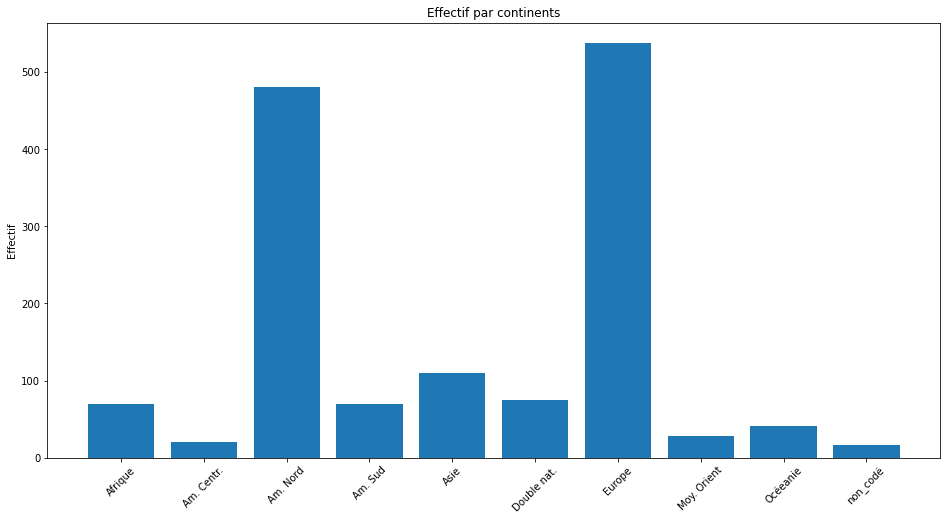

In [111]:
# Distribution par année

objects = [l for l in df_coded_nat.index]
eff = [l for l in df_coded_nat['effectif']]

p1 = plt.bar(objects, eff)

#plt.xticks(l5Years)
plt.ylabel('Effectif')
plt.title('Effectif par continents')
plt.gcf().set_size_inches(16, 8)
#plt.gca().axes.get_xaxis().set_visible(False)
# supported formats: eps, pdf, pgf, png, ps, raw, rgba, svg, svgz
#plt.savefig('exported_pictures/effectifs_naissances_par_annee.png', dpi=100, bbox_inches = "tight") #pdf, svg
plt.xticks(rotation=45)
plt.show()


In [112]:
values_l = [x[0] for x in sorted_coded_nat_list]
values_l

['Europe',
 'Am. Nord',
 'Asie',
 'Double nat.',
 'Afrique',
 'Am. Sud',
 'Océeanie',
 'Moy. Orient',
 'Am. Centr.',
 'non_codé']

In [113]:
### Transformer les années en entiers
int_coded_nat_list = [[int(l[0]), l[1]] for l in coded_nat_list]

In [114]:
## écrire le résultat puis l'ouvrir dans Calc ou Excel afin d'effectuer le codage
file= 'spreadsheets/continents_annees.csv'
with open(file, 'w', newline='') as csvfile:
    writ = csv.writer(csvfile, delimiter='|',
                            quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writ.writerow(['annee', 'continent'])
    for l in int_coded_nat_list:
        writ.writerow(l)

In [115]:
### Create a list with intervals of 10 years, corresponding approximately to one generation.

def create_years_list(period = 10, y_start = 1391, y_end = 1801):

    y_list = []
    y_list.append(y_start)

    while y_start < y_end:
        y_start += period
        y_list.append(y_start)
    return y_list    

In [116]:
def interactive_nationality_periods(nationality, period = 10, remaining = False):
    
    output_l = []
    work_l = int_coded_nat_list # les années doivent être des entiers
    for a in nationality:
        prov_l = []
        for l in work_l:            
            if a == l[1]:
                output_l.append(l)
            else:
                prov_l.append(l)
        work_l = prov_l

    print('Nationalités: ', len(output_l))
    print('Les autres (non chosis): ',len(work_l))
    # print('\n-----')
    
    period = period # 20 10
    y_list = create_years_list(period = period, y_start = 1771, y_end = 2021)
    
    
    
    with plt.style.context("ggplot"):
                
        fig, ax = plt.subplots(figsize=(16,8)) 


        width =  period - (period * 20 / 100)

        bottom_list = []
        i = 0
        while i < len(y_list):
            bottom_list.append(0)
            i += 1

        if remaining:
            i_list = []
            for i in y_list:
                i_n = 0
                for l in work_l:
                    if int(l[0]) >= i and int(l[0]) < (i + period):
                        i_n += 1
                i_list.append([i, i_n]) 
            # print('BBB: ', i_list)            
            draw_l = [i[1] for i in i_list]
            ax.bar(y_list, draw_l, width, bottom = bottom_list, label='remaining' ) #, bottom = bottom_list)
            bottom_list = [x + y for x, y in zip(bottom_list, draw_l)]


        for a in nationality:
            i_list = []
            for i in y_list:
                i_n = 0
                for l in output_l:
                    if l[1] == a and int(l[0]) >= i and int(l[0]) < (i + period):
                        i_n += 1
                i_list.append([i, i_n]) 
            # print('AAA: ', i_list)            
            draw_l = [i[1] for i in i_list]
            ax.bar(y_list, draw_l, width, bottom = bottom_list, label=a ) #, bottom = bottom_list)
            bottom_list = [x + y for x, y in zip(bottom_list, draw_l)]
            # print(bottom_list)



        ax.set_ylabel('Fréq')
        ax.set_title('Fréquence par nationalité')
        plt.xticks(y_list,rotation=45)

        ax.legend()

        p_out = plt.show()

In [117]:
k = interactive(interactive_nationality_periods, nationality=SelectMultiple(
    options=sorted(values_l),
    value=['Europe'],
    #rows=10,
    description='Nationalités',
    disabled=False
),  period=IntSlider(min=5, max=50, step=5, value=20),
    remaining = Checkbox(
    value=False,
    description='Les autres (non choisis)',
    disabled=False
))

In [118]:
display(k)
# dir(k)

interactive(children=(SelectMultiple(description='Nationalités', index=(6,), options=('Afrique', 'Am. Centr.',…